# Impacto de la métrica evaluadora en el caso de etiquetas probabilidades

Para el caso en que se tienen etiquetas no categóricas $y_i$, sino que es un vector de la probabilidad $p_i$ sobre cada una de las $K$ clases se pueden optar por distintas formas para entrenar estos modelos, en donde la métrica evaluadora (**Función objetivo**) resulta crucial para obtener un buen modelo que aproxime toda la distribución de probabilidad en los datos $\hat{p}_i$, no solo la clase mayoritaria (en el caso de etiqueta única o categorica) o las clases con mayor probabilidad, sino que aproxime toda la incerteza del dato, incluyendo la interteza en las clases menos probables, sin asignar probabilidad 0 a éstas ($\hat{p}_i \neq 0$).

En particular nos basaremos en las métricas de divergencia de Bregman... sobre esto..


**Obj:**

**Hipótesis**: Una métrica evaluadora (función objetivo) basada en distribuciones de probabilidad logra imitar mejor el comportamiento que una métrica estándar de variables continuas.


In [1]:
import keras,gc, pickle,time,json
from keras import backend as K
from keras import losses
from keras.models import load_model,Sequential
from keras.preprocessing import sequence
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.layers import *
from IPython.display import SVG
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
!ls

GalaxyZoo_kaggle		  Sentiment
images_test.npy			  Trabajo.ipynb
images_train.npy		  train_models
IMDB Movie Genre Dataset.json	  train_models1
Leer Datasets - GalaxyZoo.ipynb   train_models2
model.png			  TweetsEmotion
News Classification DataSet.json


### All losses used

In [3]:
##Define all losses used

#all with axis =-1 .. the last axis is take to the pi

def KL_divergence_reverse(y_true, y_pred): #KL(pred|true)  
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_pred* K.log(y_pred/ y_true), axis=-1)

#MSE?
def mse(y_true,y_pred):   #        <<<---keras
    return K.mean(K.square(y_pred - y_true), axis=-1) #??

#RMSE
def rmse(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
#mal implementado para multiples dimensiones.. --> solucion: euclidian distance 


##-----------------------------BREGMAN FRAMEWORK-------------------------------
#https://en.wikipedia.org/wiki/Bregman_divergence
def KL_divergence_forward(y_true, y_pred): #KL(true|pred) <<<---keras
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def euclidean_distance(y_true,y_pred): #also sse    #squared      
    return K.sum(K.square(y_pred - y_true), axis=-1) #??

def crossentropy(y_true, y_pred): #categorical             <<<---keras
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return -1.*K.sum(y_true * K.log(y_pred), axis=-1)

def itakura_saito(y_true,y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1) #quizas no es necesario
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    
    return K.sum(y_true/y_pred - K.log(y_true/y_pred) -1 , axis=-1)
#but is not a true metric since it is not symmetric[3] and it does not fulfil triangle inequality.

def generalized_I_divergence(y_true,y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1) #quizas no es necesario
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    
    return K.sum(y_true * K.log(y_true / y_pred) - (y_true-y_pred) , axis=-1)
##-------------------------------BREGMAN-------------------------------


def symmetric_KL(y_true,y_pred): #jensen-shanon
    return KL_divergence_forward(y_true, (y_pred+y_true)/2 )  + KL_divergence_forward(y_pred,(y_pred+y_true)/2)
#simetrica y minimo exacto en y_true=y_pred

#el mean en el batch se hace en el fit.. esto es por ejemplo.
keras.losses.symmetric_KL = symmetric_KL
keras.losses.generalized_I_divergence = generalized_I_divergence
keras.losses.itakura_saito =itakura_saito 
keras.losses.crossentropy =euclidean_distance
keras.losses.KL_divergence_forward = KL_divergence_forward
keras.losses.euclidean_distance = euclidean_distance
keras.losses.mse = mse 
keras.losses.rmse =rmse
keras.losses.KL_divergence_reverse = KL_divergence_reverse

In [4]:
a = [[0,1,0],[0.1,0,0.9],[0.5,0.3,0.2]]
worst = [[0.5,0,0.5],[0,1,0.],[0,0,1]]
a = tf.convert_to_tensor(a, dtype=tf.float32)#np.asarray([,dtype=np.float32) #
worst = tf.convert_to_tensor(worst, dtype=tf.float32) #np.asarray([[0,1,0],[1,0,0]],dtype=np.float32) #tf.convert_to_tensor([2,1,2], dtype=tf.float32)

print("-------------Mejor")
print("KL-reverse:",K.eval(KL_divergence_reverse(a,a)))
print("MSE:",K.eval(mse(a,a)))
print("RMSE:",K.eval(rmse(a,a)))
print("(bregam)KL-forward:",K.eval(KL_divergence_forward(a,a)))
print("(bregam)Eucledian-D:",K.eval(euclidean_distance(a,a)))
print("(bregam)crossentropy:",K.eval(crossentropy(a,a)))
print("(bregam)itakura_saito:",K.eval(itakura_saito(a,a)))
print("(bregam)Generalize-I:",K.eval(generalized_I_divergence(a,a)))
print("symmetric-KL:",K.eval(symmetric_KL(a,a)))

print("-------------Peor")
print("KL-reverse:",K.eval(KL_divergence_reverse(worst,a)))
print("MSE:",K.eval(mse(worst,a)))
print("RMSE:",K.eval(rmse(worst,a)))
print("(bregam)KL-forward:",K.eval(KL_divergence_forward(worst,a)))
print("(bregam)Eucledian-D:",K.eval(euclidean_distance(worst,a)))
print("(bregam)crossentropy:",K.eval(crossentropy(worst,a)))
print("(bregam)itakura_saito:",K.eval(itakura_saito(worst,a)))
print("(bregam)Generalize-I:",K.eval(generalized_I_divergence(worst,a)))
print("symmetric-KL:",K.eval(symmetric_KL(worst,a)))

-------------Mejor
KL-reverse: [0. 0. 0.]
MSE: [0. 0. 0.]
RMSE: [0. 0. 0.]
(bregam)KL-forward: [0. 0. 0.]
(bregam)Eucledian-D: [0. 0. 0.]
(bregam)crossentropy: [3.2236192e-06 3.2508460e-01 1.0296531e+00]
(bregam)itakura_saito: [0. 0. 0.]
(bregam)Generalize-I: [0. 0. 0.]
symmetric-KL: [0. 0. 0.]
-------------Peor
KL-reverse: [16.118092 15.793012 11.864823]
MSE: [0.5        0.6066666  0.32666668]
RMSE: [0.70710677 0.77888805 0.5715476 ]
(bregam)KL-forward: [15.424948 16.118092  1.609435]
(bregam)Eucledian-D: [1.5       1.8199999 0.98     ]
(bregam)crossentropy: [16.118095  16.118095   1.6094382]
(bregam)itakura_saito: [9.9999820e+06 1.0000011e+07 3.0729633e+01]
(bregam)Generalize-I: [15.424948  16.118092   1.6094347]
symmetric-KL: [1.3862898 1.38629   0.845618 ]


In [132]:

a = [[0,1,0],[1,0,0.9]]
b = [[0,1,0],[1,0,0.4]]

a = tf.convert_to_tensor(a, dtype=tf.float32)#np.asarray([,dtype=np.float32) #
b = tf.convert_to_tensor(b, dtype=tf.float32) #np.asarray([[0,1,0],[1,0,0]],dtype=np.float32) #tf.convert_to_tensor([2,1,2], dtype=tf.float32)

print(K.int_shape(a))

K.eval(mse(a,b))

(2, 3)


array([0.        , 0.08333332], dtype=float32)

### Load Data

In [ ]:
#load all the batch you can, if not you can keep training the model by every batch
df_train_batch1 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande//train_batch1.csv.gz",header=None)
df_train_batch2 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch2.csv.gz",header=None)
#df_train_batch3 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch3.csv.gz",header=None)
#df_train_batch4 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch4.csv.gz",header=None)
#df_train_batch5 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch5.csv.gz",header=None)
df_train = pd.concat([df_train_batch1,df_train_batch2],axis=0)

df_test = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/test.csv.gz",header=None)
print("Dimensiones training: ",df_train.shape)
print("Dimensiones test: ",df_test.shape)
df_test.head()

In [4]:
#normalize between 0 and 1
X_test = df_test.values.reshape((df_test.shape[0],3,100,100))#/255.0 
X_train = df_train.values.reshape((df_train.shape[0],3,100,100))#/255.0 

#Transpose to tensorflow dimension, the 3 chanels are the last shape
X_test = X_test.transpose([0,2, 3, 1])
X_train = X_train.transpose([0,2, 3, 1])

In [5]:
saved = np.asarray(X_train,dtype=np.uint8)
np.save('images_train',saved)
saved = np.asarray(X_test,dtype=np.uint8)
np.save('images_test',saved)

### cargarlos mas rapido

In [4]:
X_train = np.load("images_train.npy")/255.
X_test = np.load("images_test.npy")/255.

In [5]:
dataset = "GalaxyZoo"
train_labels = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/train_labels.csv")
test_labels = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test_labels.csv")
train_labels.head()

,GalaxyID,Answer1.1,Answer1.2,Answer1.3,Answer2.1,Answer2.2,Answer3.1,Answer3.2,Answer4.1,Answer4.2,...,Answer9.3,Answer10.1,Answer10.2,Answer10.3,Answer11.1,Answer11.2,Answer11.3,Answer11.4,Answer11.5,Answer11.6
0,569297,0.083065,0.916935,0.000000,0.023551,0.893384,0.107109,0.786276,0.714189,0.179195,...,0.000000,0.459257,0.254932,0.000000,0.000000,0.504446,0.000000,0.0,0.0,0.209744
1,701332,0.275109,0.713127,0.011765,0.633523,0.079604,0.079604,0.000000,0.000000,0.079604,...,0.499005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,908039,0.411643,0.587223,0.001134,0.234878,0.352345,0.000000,0.352345,0.205471,0.146874,...,0.026647,0.205471,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.205471
3,401459,0.013316,0.986684,0.000000,0.000000,0.986684,0.753419,0.233265,0.986684,0.000000,...,0.000000,0.350273,0.381847,0.254564,0.191225,0.508621,0.095613,0.0,0.0,0.191225
4,607293,0.829407,0.128859,0.041733,0.021519,0.107340,0.000000,0.107340,0.000000,0.107340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [47]:
train_labels.loc[:,["Answer7.1","Answer7.2","Answer7.3","Answer6.1","Answer6.2"]]

,Answer7.1,Answer7.2,Answer7.3,Answer6.1,Answer6.2
0,0.009905,0.065543,0.007618,0.092941,0.907059
1,0.000000,0.000000,0.275109,0.000000,1.000000
2,0.017089,0.106117,0.288438,0.000000,1.000000
3,0.013316,0.000000,0.000000,0.566929,0.433071
4,0.653463,0.175944,0.000000,0.000000,1.000000
5,0.307135,0.008622,0.000000,0.309360,0.690640
6,0.000000,0.084466,0.182252,0.135404,0.864596
7,0.020865,0.022973,0.000000,0.394753,0.605247
8,0.000000,0.264640,0.036594,0.000000,1.000000
9,0.000000,0.230718,0.007810,0.156834,0.843166


In [11]:
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer2.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values


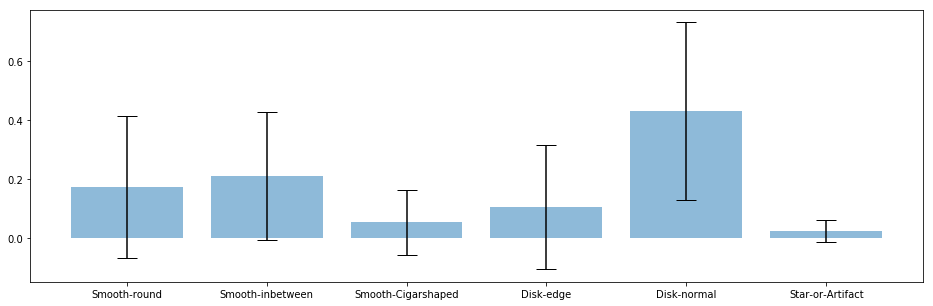

In [12]:
plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

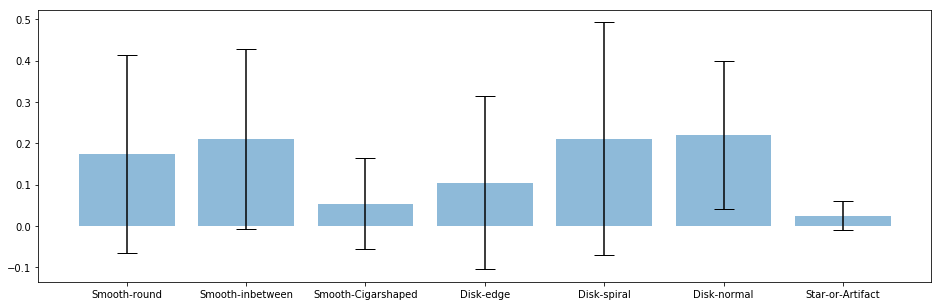

In [41]:
#granulada
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-spiral","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer4.1","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

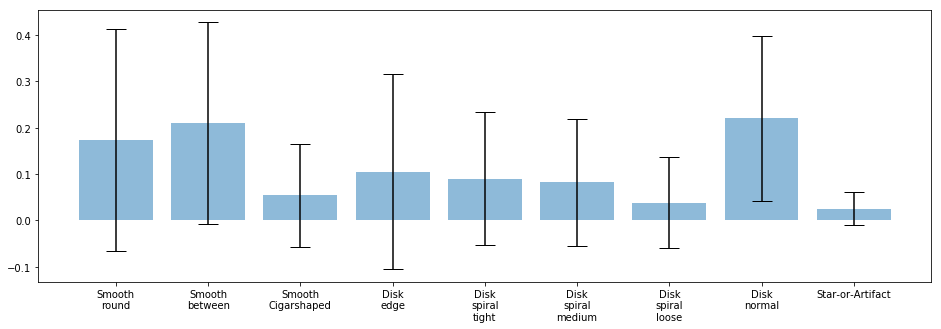

In [6]:
#mas granulada
labels = ["Smooth\nround","Smooth\nbetween","Smooth\nCigarshaped","Disk\nedge","Disk\nspiral\ntight","Disk\nspiral\nmedium","Disk\nspiral\nloose","Disk\nnormal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer10.1","Answer10.2","Answer10.3","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

In [43]:
#Chequeo
np.sum(y_train,axis=-1)

array([1.        , 1.000001  , 1.00000041, ..., 0.99999835, 1.        ,
       0.999999  ])

### Tweets Emotion
----
https://www.kaggle.com/fernandojvdasilva/stock-tweets-ptbr-emotions

In [4]:
dataset="Tweets"
df_annotations = pd.read_csv("TweetsEmotion/tweets_annotations.csv")
df_tweets = pd.read_csv("TweetsEmotion/tweets.csv")

#df = pd.read_csv("Sentiment/Apple-Twitter-Sentiment-DFE.csv")
 
df_annotations.head()

,trust_vs_disgust,surprise_vs_antecip,tweet_id,joy_vs_sadness,key,created_date,annotator_id,anger_vs_fear
0,dontknow,dontknow,443345540483665920,dontknow,4503759984001024,2017-01-24T12:31:49,6503,dontknow
1,TRU,neutral,468948000140951552,JOY,4503815348813824,2017-01-21T17:29:59,4645,neutral
2,neutral,neutral,458274836494946305,neutral,4503850715185152,2017-01-20T16:14:14,6539,neutral
3,neutral,neutral,444090187128135680,neutral,4504332019957760,2017-01-20T13:44:40,2798,neutral
4,neutral,neutral,453998678693675010,neutral,4504712392998912,2017-01-22T02:23:17,8927,neutral


In [8]:
df_annotations.shape

(13756, 8)

In [19]:
len(df_annotations["annotator_id"].unique())

442

In [17]:
df_tweets[(df_tweets["num_annot"]!=0)].shape

(4553, 5)

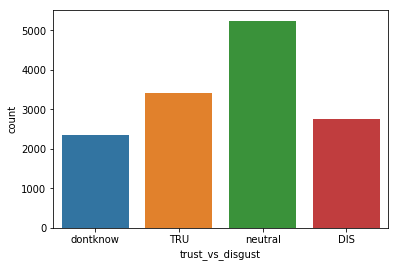

In [9]:
sns.countplot('trust_vs_disgust',data=df_annotations)

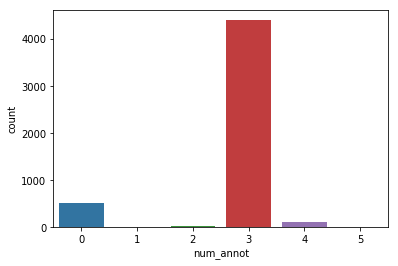

In [18]:
sns.countplot('num_annot',data=df_tweets)

In [69]:
id_text = {}
for dato in df_tweets.values:
    if dato[0]!=0:
        id_text[dato[-1]] = dato[1]
        
text_input = {}
text_label = {}
for dato in df_annotations.values:
    tweet_id = dato[2]
    emotions = [dato[0],dato[1],dato[3],dato[7]]     
    if emotions.count("neutral")>3: # o iwal
        emotions = list(set(emotions))
    else:
        indexes, = np.where(emotions=="neutral")
        emotions = np.delete(emotions,indexes).tolist()
    
    if tweet_id not in text_input:
        text_input[tweet_id] = id_text[tweet_id]
        text_label[tweet_id] = emotions
    else:
        text_label[tweet_id] += emotions

In [70]:
## a vector de proba...
posibles_labels =  ["TRU","DIS","SUR","ANT","JOY","SAD","ANG","FEA","neutral"]
#["JOY","SAD","neutral","dontknow"]
probas = []
texts = []
for identificador,anotations in text_label.items():
    aux = np.zeros(len(posibles_labels))
    for i,posible in enumerate(posibles_labels):
        aux[i] = anotations.count(posible)
    if np.sum(aux) != 0:
        probas.append(aux)
        texts.append(text_input[identificador])
probas = np.asarray(probas)
texts = np.asarray(texts)
y = probas/np.sum(probas,axis=-1)[:,None]
del probas
y.shape

(4532, 9)

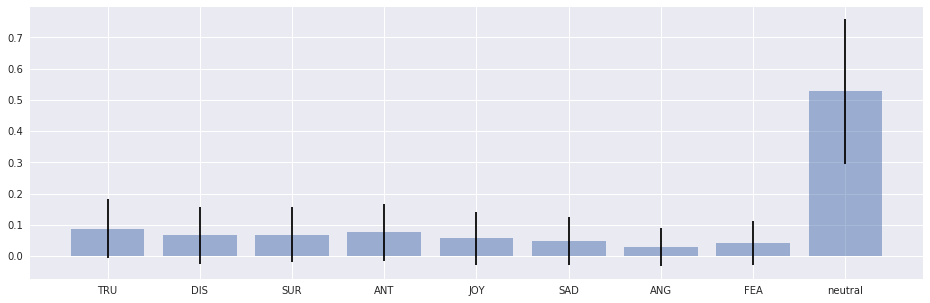

In [75]:
plt.figure(figsize=(16,5))
plt.bar(np.arange(y.shape[1]),np.mean(y,axis=0),yerr=np.std(y,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y.shape[1]),posibles_labels)
plt.show()

In [40]:
### preprocess texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

commonwords = stopwords.words('portuguese')
aux = []
for text in texts:
    tokens = word_tokenize(text.lower())
    aux.append([token for token in tokens if token not in commonwords])
texts = aux

In [41]:
from gensim.models import Word2Vec
vector_size = 100
#model_word2vec = Word2Vec(texts, size=vector_size, window=5, min_count=10, workers=4)
model_word2vec = Word2Vec(texts, size=vector_size, window=5, min_count=5, workers=4)

print(model_word2vec)
model_word2vec.train(texts,total_examples=len(texts),epochs=10)

vocab_input =  model_word2vec.wv.vocab 
word_index = vocab_input.keys()
word_index = {word:i+1 for i,word in enumerate(word_index)}

nb_words = len(model_word2vec.wv.vocab)
embedding_matrix = np.zeros((nb_words+1, vector_size))
for word, i in word_index.items():
    embedding_vector = model_word2vec.wv[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Word2Vec(vocab=1626, size=100, alpha=0.025)


In [10]:
#de 12 mil a 840

In [42]:
X = np.asarray([[word_index[token] for token in sentence if token in vocab_input] for sentence in texts])

max_input_lenght = np.max(list(map(len,X)))
X = sequence.pad_sequences(X,maxlen=max_input_lenght,padding='pre',value=0) 

print("Dimensionalidades input: ",X.shape)
X

Dimensionalidades input:  (4532, 38)


array([[   0,    0,    0, ..., 1355, 1333,  938],
       [   0,    0,    0, ..., 1405,  429,  724],
       [   0,    0,    0, ...,  310, 1333,  938],
       ...,
       [   0,    0,    0, ...,  781, 1112,   55],
       [   0,    0,    0, ..., 1472,  373, 1473],
       [   0,    0,    0, ..., 1163, 1333,  938]], dtype=int32)

In [43]:
##train test split...
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Dimensionalidades input (training): ",X_train.shape)
print("Dimensionalidades input (test): ",X_test.shape)
print("Dimensionalidades output (training): ",y_train.shape)
print("Dimensionalidades output (test): ",y_test.shape)

Dimensionalidades input (training):  (3036, 38)
Dimensionalidades input (test):  (1496, 38)
Dimensionalidades output (training):  (3036, 9)
Dimensionalidades output (test):  (1496, 9)


### Crowd Tumor
----
https://www.kaggle.com/kmader/crowds-cure-cancer-2017

### Define model

In [13]:
#metaparametros
Iterations = 4
opt = 'adam' #rmsprop?
batch_size = 128
epochs = 20

In [14]:
def define_modelI(loss,show_summary=False):
    model = Sequential()
    #model.add(Embedding(top_words, embedding_vector_length, input_length=500))
    model.add(Embedding(output_dim=vector_size, input_dim=nb_words+1,weights=[embedding_matrix], 
                         input_length=max_input_lenght, trainable=False,mask_zero=True))
    model.add(GRU(128,return_sequences=True)) #CuDNNGRU
    model.add(Dropout(0.3))
    model.add(GRU(128,return_sequences=False))
    model.add(Dropout(0.3))    
    model.add(Dense(y_test.shape[1], activation='softmax'))
    
    if show_summary:
        model.summary()
    model.compile(optimizer=opt, loss=loss) 
    return model
model_text = define_modelI(crossentropy,show_summary=True) #crossentropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 38, 100)           162700    
_________________________________________________________________
gru_1 (GRU)                  (None, 38, 128)           87936     
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 350,485
Trainable params: 187,785
Non-trainable params: 162,700
________________________________________________________________

In [9]:
#http://benanne.github.io/2014/04/05/galaxy-zoo.html
#ganadora galaxyzoo challenge

def define_modelI(loss,show_summary=False):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (6, 6), padding='valid', input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64, (5, 5), padding='valid',activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(128, (3, 3), padding='valid',activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='valid',activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_test.shape[1],activation='softmax'))
    if show_summary:
        model.summary()
    model.compile(optimizer=opt, loss=loss) 
    return model
model_image = define_modelI(euclidean_distance,show_summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 95, 95, 32)        3488      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [7]:
def define_modelI(loss,show_summary=False):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(2,2))
    #filtros de 5x5 
    #model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(2,2))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(2,2))
    #model.add(BatchNormalization())

    #model.add(Conv2D(128, (3, 3), padding='same',activation='relu',strides=2))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(y_test.shape[1],activation='softmax'))
    if show_summary:
        model.summary()
    model.compile(optimizer=opt, loss=loss) 
    return model
model_image = define_modelI(crossentropy,show_summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
__________

In [13]:
plot_model(model_image, to_file='model.png',show_shapes=True,rankdir='TB')

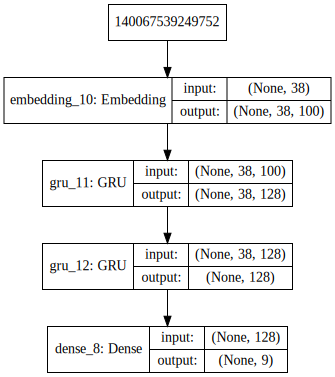

In [79]:
SVG(model_to_dot(model_text,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
#callback que detiene? 

In [15]:
def delta_conv(loss_t,loss_t1):
    return np.abs(loss_t-loss_t1)/loss_t
def delta_loss(array_loss):
    loss_conv = [np.nan]
    for i in range(1,len(array_loss)):
        loss_conv.append(delta_conv(array_loss[i-1],array_loss[i]))
    return loss_conv

def train_loss(loss,verbose=1):
    print("--------------------------------------\nLoss: ",loss)
    historys = []
    delta = []
    val_historys = []
    val_delta =[]
    for i in range(Iterations):
        model_image = define_modelI(loss)
        #hist = model_image.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),verbose=verbose)
        hist = model_text.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),verbose=verbose)
        historys.append(hist.history['loss'])
        val_historys.append(hist.history['val_loss'])
        delta.append(delta_loss(hist.history["loss"]))
        val_delta.append(delta_loss(hist.history["val_loss"]))
        if i < Iterations-1:
            del model_image 
    y = np.mean(historys,axis=0)
    e = np.std(historys,axis=0)
    y_val = np.mean(val_historys,axis=0)
    e_val = np.std(val_historys,axis=0)
    return [y,e],[y_val,e_val],[np.mean(delta,axis=0),np.std(delta,axis=0)], [np.mean(val_delta,axis=0),np.std(val_delta,axis=0)], model_image

## train model with different losses

In [17]:
#normal
try:
    loss_kl_reverse,val_loss_kl_reverse, lossD_kl_reverse,val_lossD_kl_reverse, model_klreverse = train_loss(KL_divergence_reverse)
    model_klreverse.save("train_models/Model_KL_Reverse_"+dataset+".h5")
    file = open("train_models/aux_KL_Reverse_"+dataset+".pickle",'wb')
    pickle.dump([loss_kl_reverse,val_loss_kl_reverse, lossD_kl_reverse,val_lossD_kl_reverse],file)
    file.close()
    del loss_kl_reverse,val_loss_kl_reverse, lossD_kl_reverse,val_lossD_kl_reverse,model_klreverse
    gc.collect()
except:
    print("KL Reverse no termino")

--------------------------------------
Loss:  <function KL_divergence_reverse at 0x7f1840ae9e18>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 7s 2ms/step - loss: 1.6517 - val_loss: 1.5179
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.5173 - val_loss: 1.5013
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.5080 - val_loss: 1.4889
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4993 - val_loss: 1.4871
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4913 - val_loss: 1.4859
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4885 - val_loss: 1.4798
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4859 - val_loss: 1.4755
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4815 - val_loss: 1.4773
Epoch 9/20
3036/3036 [=================

3036/3036 [==============================] - 4s 1ms/step - loss: 1.2899 - val_loss: 1.5989
Epoch 19/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2894 - val_loss: 1.5993
Epoch 20/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2842 - val_loss: 1.6118


In [18]:
try:
    loss_mse, val_loss_mse,lossD_mse, val_lossD_mse, model_mse = train_loss(mse)    
    model_mse.save("train_models/Model_MSE_"+dataset+".h5")
    file = open("train_models/aux_MSE_"+dataset+".pickle",'wb')
    pickle.dump([loss_mse, val_loss_mse,lossD_mse, val_lossD_mse],file)
    file.close()
    del loss_mse, val_loss_mse,lossD_mse, val_lossD_mse, model_mse
    gc.collect()
except:
    print("MSE no termino")

--------------------------------------
Loss:  <function mse at 0x7f1840ae9f28>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.2848 - val_loss: 1.6038
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2835 - val_loss: 1.6079
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2825 - val_loss: 1.6023
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2783 - val_loss: 1.6071
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2788 - val_loss: 1.6153
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2742 - val_loss: 1.6236
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2687 - val_loss: 1.6153
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2695 - val_loss: 1.6217
Epoch 9/20
3036/3036 [==============================] - 4

In [19]:
try:
    loss_rmse, val_loss_rmse,lossD_rmse, val_lossD_rmse,model_rmse = train_loss(rmse)
    model_rmse.save("train_models/Model_RMSE_"+dataset+".h5")
    file = open("train_models/aux_RMSE_"+dataset+".pickle",'wb')
    pickle.dump([loss_rmse, val_loss_rmse,lossD_rmse, val_lossD_rmse],file)
    file.close()
    del loss_rmse, val_loss_rmse,lossD_rmse, val_lossD_rmse,model_rmse
    gc.collect()
except:
    print("RMSE no termino")

--------------------------------------
Loss:  <function rmse at 0x7f1840af8268>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.1808 - val_loss: 1.7426
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1824 - val_loss: 1.7488
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1799 - val_loss: 1.7416
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1804 - val_loss: 1.7402
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1778 - val_loss: 1.7494
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1786 - val_loss: 1.7450
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1788 - val_loss: 1.7482
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1799 - val_loss: 1.7380
Epoch 9/20
3036/3036 [==============================] - 

In [20]:
try:
    loss_symetricKL, val_loss_symetricKL,lossD_symetricKL, val_lossD_symetricKL,model_symmetricKL = train_loss(symmetric_KL)
    model_symmetricKL.save("train_models/Model_symmetricKL_"+dataset+".h5")
    file = open("train_models/aux_symmetricKL_"+dataset+".pickle",'wb')
    pickle.dump([loss_symetricKL, val_loss_symetricKL,lossD_symetricKL, val_lossD_symetricKL],file)
    file.close()
    del loss_symetricKL, val_loss_symetricKL,lossD_symetricKL, val_lossD_symetricKL,model_symmetricKL
    gc.collect()
except:
    print("symmetricKL no termino")

--------------------------------------
Loss:  <function symmetric_KL at 0x7f1840af8620>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.1451 - val_loss: 1.8251
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1436 - val_loss: 1.8289
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1426 - val_loss: 1.8430
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1439 - val_loss: 1.8338
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1448 - val_loss: 1.8170
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1429 - val_loss: 1.8182
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1416 - val_loss: 1.8447
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1402 - val_loss: 1.8308
Epoch 9/20
3036/3036 [==========================

In [21]:
try:
    loss_crossentropy, val_loss_crossentropy,lossD_crossentropy, val_lossD_crossentropy,model_crossentropy = train_loss(crossentropy)
    model_crossentropy.save("train_models/Model_crossentropy_"+dataset+".h5")
    file = open("train_models/aux_crossentropy_"+dataset+".pickle",'wb')
    pickle.dump([loss_crossentropy, val_loss_crossentropy,lossD_crossentropy, val_lossD_crossentropy],file)
    file.close()
    del loss_crossentropy, val_loss_crossentropy,lossD_crossentropy, val_lossD_crossentropy,model_crossentropy 
    gc.collect()
except:
    print("Cross entropy no termino")

--------------------------------------
Loss:  <function crossentropy at 0x7f1840af8158>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.1248 - val_loss: 1.8922
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1241 - val_loss: 1.8879
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1271 - val_loss: 1.8823
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1256 - val_loss: 1.8881
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1259 - val_loss: 1.8794
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1245 - val_loss: 1.8881
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1255 - val_loss: 1.8875
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1223 - val_loss: 1.8936
Epoch 9/20
3036/3036 [==========================

### bregman

In [16]:
try:
    loss_kl_forward, val_loss_kl_forward,lossD_kl_forward, val_lossD_kl_forward,model_klforward = train_loss(KL_divergence_forward)
    model_klforward.save("train_models/Model_KL_forward_"+dataset+".h5")
    file = open("train_models/aux_KL_forward_"+dataset+".pickle",'wb')
    pickle.dump([loss_kl_forward, val_loss_kl_forward,lossD_kl_forward, val_lossD_kl_forward],file)
    file.close()
    del loss_kl_forward, val_loss_kl_forward,lossD_kl_forward, val_lossD_kl_forward,model_klforward 
    gc.collect()
except:
    print("KL Forward no termino")

--------------------------------------
Loss:  <function KL_divergence_forward at 0x7fc437134268>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 7s 2ms/step - loss: 1.6464 - val_loss: 1.5150
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.5191 - val_loss: 1.4960
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.5062 - val_loss: 1.4915
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4987 - val_loss: 1.4843
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4939 - val_loss: 1.4837
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4918 - val_loss: 1.4830
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4876 - val_loss: 1.4779
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.4832 - val_loss: 1.4768
Epoch 9/20
3036/3036 [=================

3036/3036 [==============================] - 4s 1ms/step - loss: 1.2912 - val_loss: 1.5983
Epoch 19/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2887 - val_loss: 1.5979
Epoch 20/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2840 - val_loss: 1.6032


In [17]:
try:
    loss_euclidean, val_loss_euclidean,lossD_euclidean, val_lossD_euclidean,model_euclidean = train_loss(euclidean_distance)
    model_euclidean.save("train_models/Model_EuclideanD_"+dataset+".h5")
    file = open("train_models/aux_EuclideanD_"+dataset+".pickle",'wb')
    pickle.dump([loss_euclidean, val_loss_euclidean,lossD_euclidean, val_lossD_euclidean],file)
    file.close()
    del loss_euclidean, val_loss_euclidean,lossD_euclidean, val_lossD_euclidean,model_euclidean
    gc.collect()
except:
    print("Euclidean distance no termino")

--------------------------------------
Loss:  <function euclidean_distance at 0x7fc4371340d0>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.2858 - val_loss: 1.6034
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2817 - val_loss: 1.6099
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2820 - val_loss: 1.6073
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2753 - val_loss: 1.6112
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2778 - val_loss: 1.6105
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2711 - val_loss: 1.6183
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2699 - val_loss: 1.6222
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.2686 - val_loss: 1.6258
Epoch 9/20
3036/3036 [====================

3036/3036 [==============================] - 4s 1ms/step - loss: 1.1854 - val_loss: 1.7419
Epoch 19/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1830 - val_loss: 1.7364
Epoch 20/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1814 - val_loss: 1.7448


In [18]:
try:
    loss_itakurasaito, val_loss_itakurasaito,lossD_itakurasaito, val_lossD_itakurasaito,model_itakuras = train_loss(itakura_saito)
    model_itakuras.save("train_models/Model_ItakuraS_"+dataset+".h5")
    file = open("train_models/aux_ItakuraS_"+dataset+".pickle",'wb')
    pickle.dump([loss_itakurasaito, val_loss_itakurasaito,lossD_itakurasaito, val_lossD_itakurasaito],file)
    file.close()
    del loss_itakurasaito, val_loss_itakurasaito,lossD_itakurasaito, val_lossD_itakurasaito,model_itakuras 
    gc.collect()
except:
    print("Itakura Saito no termino")

--------------------------------------
Loss:  <function itakura_saito at 0x7fc437134488>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.1816 - val_loss: 1.7398
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1812 - val_loss: 1.7379
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1791 - val_loss: 1.7431
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1803 - val_loss: 1.7429
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1806 - val_loss: 1.7354
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1795 - val_loss: 1.7422
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1792 - val_loss: 1.7406
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1780 - val_loss: 1.7402
Epoch 9/20
3036/3036 [=========================

In [19]:
try:
    loss_generalizedI, val_loss_generalizedI,lossD_generalizedI, val_lossD_generalizedI,model_generalizedI = train_loss(generalized_I_divergence)
    model_generalizedI.save("train_models/Model_GeneralizedI_"+dataset+".h5")
    file = open("train_models/aux_GeneralizedI_"+dataset+".pickle",'wb')
    pickle.dump([loss_generalizedI, val_loss_generalizedI,lossD_generalizedI, val_lossD_generalizedI],file)
    file.close()
    del loss_generalizedI, val_loss_generalizedI,lossD_generalizedI, val_lossD_generalizedI,model_generalizedI 
    gc.collect()
except:
    print("GeneralizedI no termino")

--------------------------------------
Loss:  <function generalized_I_divergence at 0x7fc437134598>
Train on 3036 samples, validate on 1496 samples
Epoch 1/20
3036/3036 [==============================] - 5s 2ms/step - loss: 1.1447 - val_loss: 1.8225
Epoch 2/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1435 - val_loss: 1.8294
Epoch 3/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1450 - val_loss: 1.8152
Epoch 4/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1439 - val_loss: 1.8180
Epoch 5/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1427 - val_loss: 1.8135
Epoch 6/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1426 - val_loss: 1.8182
Epoch 7/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1425 - val_loss: 1.8162
Epoch 8/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1424 - val_loss: 1.8233
Epoch 9/20
3036/3036 [==============

3036/3036 [==============================] - 4s 1ms/step - loss: 1.1262 - val_loss: 1.8821
Epoch 19/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1270 - val_loss: 1.8769
Epoch 20/20
3036/3036 [==============================] - 4s 1ms/step - loss: 1.1266 - val_loss: 1.8632


In [20]:
print("yA entreno todo")

yA entreno todo


### Load trained models.

In [13]:
##load...
model_klreverse = load_model("train_models/Model_KL_Reverse_"+dataset+".h5")
file = open("train_models/aux_KL_Reverse_"+dataset+".pickle",'rb')
loss_kl_reverse,val_loss_kl_reverse, lossD_kl_reverse,val_lossD_kl_reverse = pickle.load(file)
file.close()

model_mse = load_model("train_models/Model_MSE_"+dataset+".h5")
file = open("train_models/aux_MSE_"+dataset+".pickle",'rb')
loss_mse, val_loss_mse,lossD_mse, val_lossD_mse = pickle.load(file)
file.close()

model_rmse = load_model("train_models/Model_RMSE_"+dataset+".h5")
file = open("train_models/aux_RMSE_"+dataset+".pickle",'rb')
loss_rmse, val_loss_rmse,lossD_rmse, val_lossD_rmse = pickle.load(file)
file.close()

model_crossentropy = load_model("train_models/Model_crossentropy_"+dataset+".h5")
file = open("train_models/aux_crossentropy_"+dataset+".pickle",'rb')
loss_crossentropy, val_loss_crossentropy,lossD_crossentropy, val_lossD_crossentropy = pickle.load(file)
file.close()

model_symmetricKL = load_model("train_models/Model_symmetricKL_"+dataset+".h5")
file = open("train_models/aux_symmetricKL_"+dataset+".pickle",'rb')
loss_symetricKL, val_loss_symetricKL,lossD_symetricKL, val_lossD_symetricKL = pickle.load(file)
file.close()

model_klforward = load_model("train_models/Model_KL_forward_"+dataset+".h5")
file = open("train_models/aux_KL_forward_"+dataset+".pickle",'rb')
loss_kl_forward, val_loss_kl_forward,lossD_kl_forward, val_lossD_kl_forward = pickle.load(file)
file.close()

model_euclidean = load_model("train_models/Model_EuclideanD_"+dataset+".h5")
file = open("train_models/aux_EuclideanD_"+dataset+".pickle",'rb')
loss_euclidean, val_loss_euclidean,lossD_euclidean, val_lossD_euclidean  = pickle.load(file)
file.close()

model_itakuras = load_model("train_models/Model_ItakuraS_"+dataset+".h5")
file = open("train_models/aux_ItakuraS_"+dataset+".pickle",'rb')
loss_itakurasaito, val_loss_itakurasaito,lossD_itakurasaito, val_lossD_itakurasaito = pickle.load(file)
file.close()

model_generalizedI = load_model("train_models/Model_GeneralizedI_"+dataset+".h5")
file = open("train_models/aux_GeneralizedI_"+dataset+".pickle",'rb')
loss_generalizedI, val_loss_generalizedI,lossD_generalizedI, val_lossD_generalizedI = pickle.load(file)
file.close()

print("Termino")

Termino


### Loss durante entrenamiento

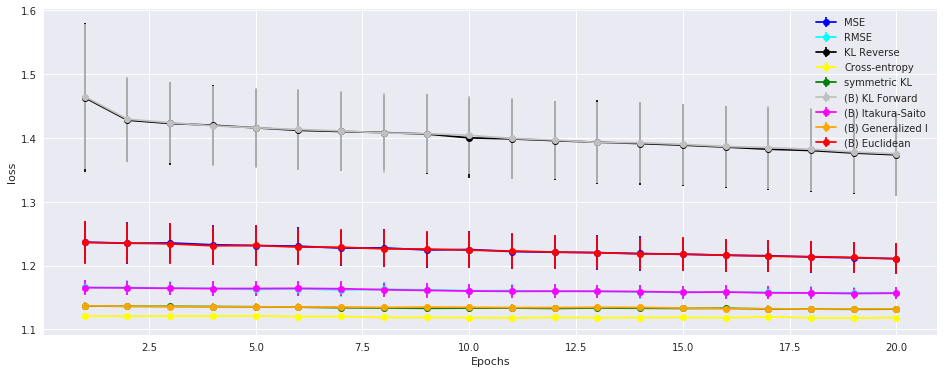

In [17]:
#entrenar varias veces y presentar variacion igual..
#lista = np.asarray([[1.,0.6,0.5],[1.,0.5,0.4],[0.9,0.5,0.3]],dtype=np.float32) #arreglo de [loss1,loss2]
import seaborn as sns
sns.set()
plt.figure(figsize=(16,6))
x = np.arange(1,1+len(loss_kl_reverse[0]))

colors = ['k','blue','cyan','g','silver','yellow','magenta','orange','red']

plt.errorbar(x, loss_mse[0], loss_mse[1],marker='o',color=colors[1],label="MSE") #None
plt.errorbar(x, loss_rmse[0], loss_rmse[1],marker='o',color=colors[2],label="RMSE") #None
plt.errorbar(x, loss_kl_reverse[0], loss_kl_reverse[1],marker='o',color=colors[0],label="KL Reverse") #None
plt.errorbar(x, loss_crossentropy[0], loss_crossentropy[1],marker='o',color=colors[5],label="Cross-entropy") #None
plt.errorbar(x, loss_symetricKL[0], loss_symetricKL[1],marker='o',color=colors[3],label="symmetric KL") #None

plt.errorbar(x, loss_kl_forward[0], loss_kl_forward[1],marker='o',color=colors[4],label="(B) KL Forward") #None
plt.errorbar(x, loss_itakurasaito[0], loss_itakurasaito[1],marker='o',color=colors[6],label="(B) Itakura-Saito") #None
plt.errorbar(x, loss_generalizedI[0], loss_generalizedI[1],marker='o',color=colors[7],label="(B) Generalized I") #None
plt.errorbar(x, loss_euclidean[0], loss_euclidean[1],marker='o',color=colors[8],label="(B) Euclidean") #None

plt.xlabel("Epochs")
plt.ylabel("loss")
#plt.ylim(0,1.3)
plt.legend()
plt.show()

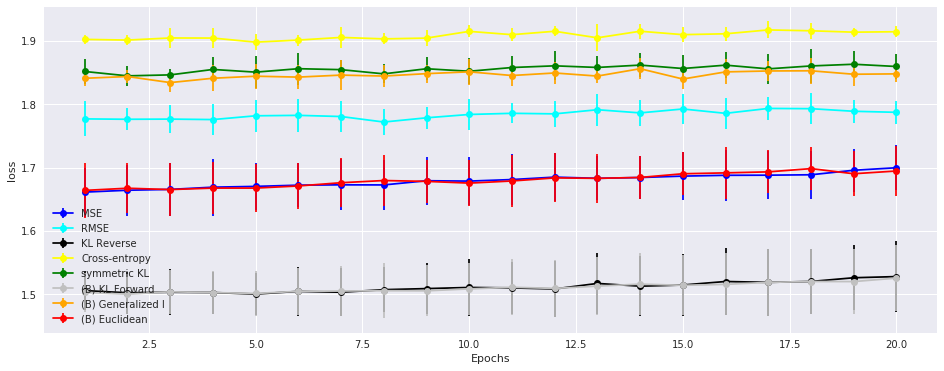

In [19]:
plt.figure(figsize=(16,6))
x = np.arange(1,1+len(loss_kl_reverse[0]))

colors = ['k','blue','cyan','g','silver','yellow','magenta','orange','red']

plt.errorbar(x, val_loss_mse[0], val_loss_mse[1],marker='o',color=colors[1],label="MSE") #None
plt.errorbar(x, val_loss_rmse[0], val_loss_rmse[1],marker='o',color=colors[2],label="RMSE") #None
plt.errorbar(x, val_loss_kl_reverse[0], val_loss_kl_reverse[1],marker='o',color=colors[0],label="KL Reverse") #None
plt.errorbar(x, val_loss_crossentropy[0], val_loss_crossentropy[1],marker='o',color=colors[5],label="Cross-entropy") #None
plt.errorbar(x, val_loss_symetricKL[0], val_loss_symetricKL[1],marker='o',color=colors[3],label="symmetric KL") #None

plt.errorbar(x, val_loss_kl_forward[0], val_loss_kl_forward[1],marker='o',color=colors[4],label="(B) KL Forward") #None
#plt.errorbar(x, val_loss_itakurasaito[0], loss_itakurasaito[1],marker='o',color=colors[6],label="(B) Itakura-Saito") #None
plt.errorbar(x, val_loss_generalizedI[0], val_loss_generalizedI[1],marker='o',color=colors[7],label="(B) Generalized I") #None
plt.errorbar(x, val_loss_euclidean[0], val_loss_euclidean[1],marker='o',color=colors[8],label="(B) Euclidean") #None

plt.xlabel("Epochs")
plt.ylabel("loss")
#plt.ylim(0,0.4)
plt.legend()
plt.show()

Escala de Itakura saito es mucho mayor (magnitud 50).. escala de mse, rmse, euclidean son muy bajas... mse es la menor...  
comportamiento: 
* KL forward igual (=) a Generalized I
* cross entropy misma curvatura que KL Forward...
* Symmetric KL simimlar a KL forward
* MSE simimlar curvatura con RMSE

## Evaluar calidad

In [12]:
def measure_error(pred,true):
    return np.mean(np.abs(pred-true),axis=0),np.std(pred-true,axis=0)

a = np.asarray([[0,1,0],[1,0.2,0.9],[1,0.9,0.4]])
b = np.asarray([[0,1,0],[1,0.9,0.4],[1,0.9,0.4]])

error_probas, errors = measure_error(y_test,model_image.predict(X_test))

plt.figure(figsize=(16,5))
plt.bar(np.arange(len(error_probas)),error_probas, yerr=errors,alpha=0.5,capsize=10)
plt.xticks(np.arange(len(error_probas)),labels)
plt.ylabel("error absoluto")
plt.show()

NameError: name 'model_image' is not defined

In [ ]:
errors

In [ ]:
error_probas

### evolucion de convergencia

Entrenamiento


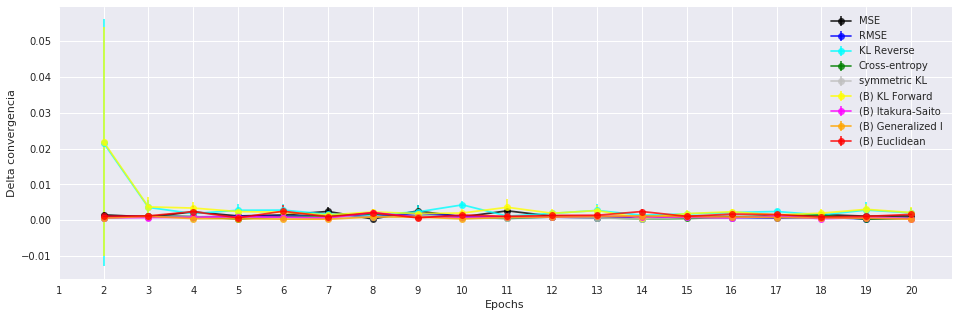

In [20]:
#evolucion de convergencia
iterate = [lossD_mse,lossD_rmse,lossD_kl_reverse,lossD_crossentropy,lossD_symetricKL
           ,lossD_kl_forward,lossD_itakurasaito,lossD_generalizedI,lossD_euclidean]   
posibles = ["MSE","RMSE","KL Reverse","Cross-entropy","symmetric KL","(B) KL Forward","(B) Itakura-Saito","(B) Generalized I","(B) Euclidean"]

print("Entrenamiento")

plt.figure(figsize=(16,5))
colors = ['k','blue','cyan','g','silver','yellow','magenta','orange','red']
x = np.arange(1,1+len(lossD_kl_reverse[0]))
for ind in range(len(posibles)):
    plt.errorbar(x,iterate[ind][0],iterate[ind][1],marker='o',color=colors[ind],label=posibles[ind],alpha=0.8 )
plt.ylabel("Delta convergencia")
plt.xlabel("Epochs")
plt.xticks(x)
plt.legend()
#plt.ylim(0,0.6)
plt.show()

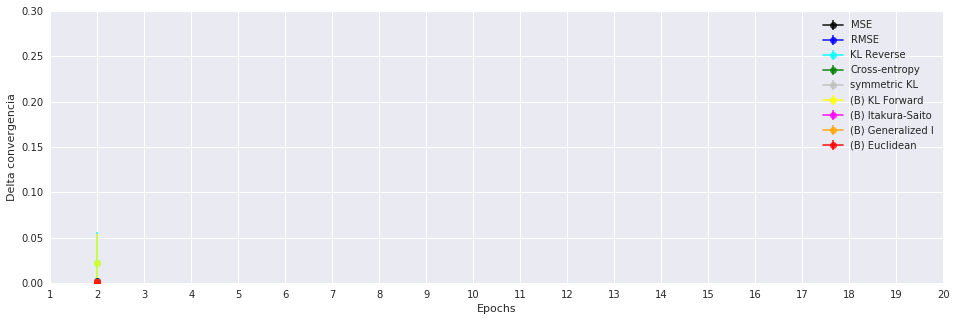

In [21]:
lim = 0.05
def stop(valor):
    aux = [np.nan]*len(valor)
    for i,valores in enumerate(valor):
        if valores <= lim:
            aux[i] = valores
            break
        aux[i] = valores
    return aux
plt.figure(figsize=(16,5))
colors = ['k','blue','cyan','g','silver','yellow','magenta','orange','red']#plt.cm.Spectral(np.linspace(0, 1, 9))
x = np.arange(1,1+len(lossD_kl_reverse[0]))
for ind in range(len(posibles)):
    plt.errorbar(x,stop(iterate[ind][0]),stop(iterate[ind][1]),marker='o',color=colors[ind],label=posibles[ind],alpha=0.8 )
plt.ylabel("Delta convergencia")
plt.xlabel("Epochs")
plt.xticks(x)
plt.legend()
plt.ylim(0,0.3)
plt.show()

mejores??...
* Itakura Saito es la primera en dejar de variar en gran escala (converge muy rapido)
* La sigue cross entropy 
* Luego frena RMSE
* Luego lo sigue KL Forward. despues KL Reverse + Symmetric KL
* Despues Generalized I
* Luego MSE
* finalmente converge Euclidean

distinto modelo:
* KL Reverse la primera, en segundo lugar Itakura saito
* Luego cross entropy
* Luego frena RMSE
* Luego lo sigue KL Forward+Generalized I
* Luego sigue symmetric KL
* Luego Euclidean
* finalmente MSE

Pruebas


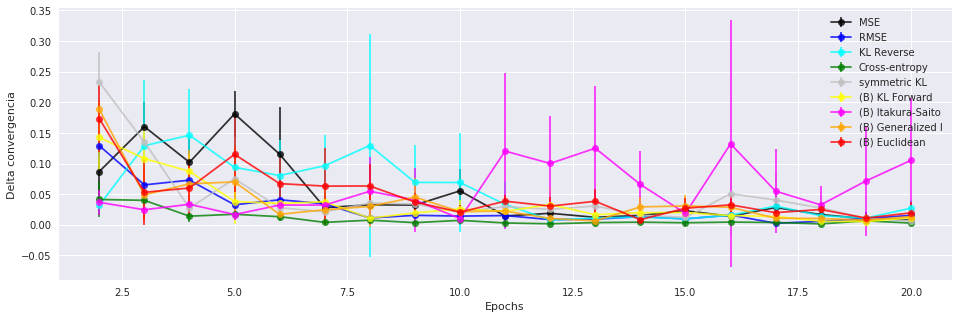

In [15]:
iterate = [val_lossD_mse,val_lossD_rmse,val_lossD_kl_reverse,val_lossD_crossentropy,val_lossD_symetricKL
           ,val_lossD_kl_forward,val_lossD_itakurasaito,val_lossD_generalizedI,val_lossD_euclidean]   
posibles = ["MSE","RMSE","KL Reverse","Cross-entropy","symmetric KL","(B) KL Forward","(B) Itakura-Saito","(B) Generalized I","(B) Euclidean"]

print("Pruebas")
plt.figure(figsize=(16,5))
for ind in range(len(posibles)):
    plt.errorbar(x,iterate[ind][0],iterate[ind][1],marker='o',color=colors[ind],label=posibles[ind],alpha=0.8 )
plt.ylabel("Delta convergencia")
plt.xlabel("Epochs")
plt.legend()
#plt.ylim(0,0.6)
plt.show()

### Prediccion top $K$ error

Pruebas


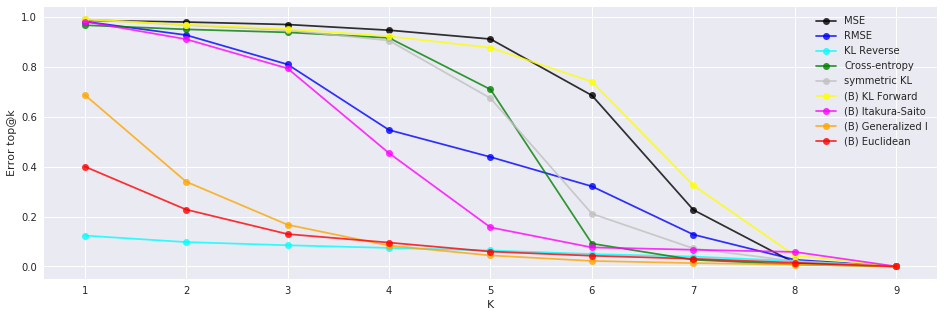

In [22]:
#prediccion...topk error
from keras.metrics import top_k_categorical_accuracy
def error_topk(ytrue,ypred,classes=5):
    return 1. - K.eval(top_k_categorical_accuracy(ytrue, ypred, k=classes))

#y_pred = np.asarray([[0.2,0.5,0.2,0.1],[0.2,0.5,0.2,0.1],[0.4,0.2,0.3,0.1]])
#y_true = np.asarray([[0,0,0,1],[0,1,0,0],[0,1,0,0]]) #majority?
#y_true = np.asarray([[0.4,0.05,0.05,0.5],[0.001,1,0.001,0.001],[0.001,1,0.001,0.001]]) #como probas.. (saca el majority)

def plot_top_k(y_true,y_pred,i,label):
    aux = []
    for k in range(1,y_true.shape[-1]+1): #len classes+1
        aux.append(error_topk(y_true,y_pred,k))
    plt.plot(np.arange(1,y_true.shape[-1]+1),aux,marker='o',color=colors[i],alpha=0.8,label=label)

iterate = [model_mse,model_rmse,model_klreverse,model_crossentropy,model_symmetricKL
           ,model_klforward,model_itakuras,model_generalizedI,model_euclidean]   
posibles = ["MSE","RMSE","KL Reverse","Cross-entropy","symmetric KL","(B) KL Forward","(B) Itakura-Saito","(B) Generalized I","(B) Euclidean"]

print("Pruebas")
colors = ['k','blue','cyan','g','silver','yellow','magenta','orange','red']
plt.figure(figsize=(16,5))

for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_test,batch_size=128)
    plot_top_k(y_test,y_pred,ind,posibles[ind]) #con test
plt.xticks(np.arange(1,y_test.shape[-1]+1))
plt.ylabel("Error top@k")
plt.xlabel("K")
#plt.ylim(0,0.4)
plt.legend()
plt.show()  

generalized y mse las menores... las peores son Itakura Saito y KL Reverse  
Ahora la mejor es KL Reverse...

Entrenamiento


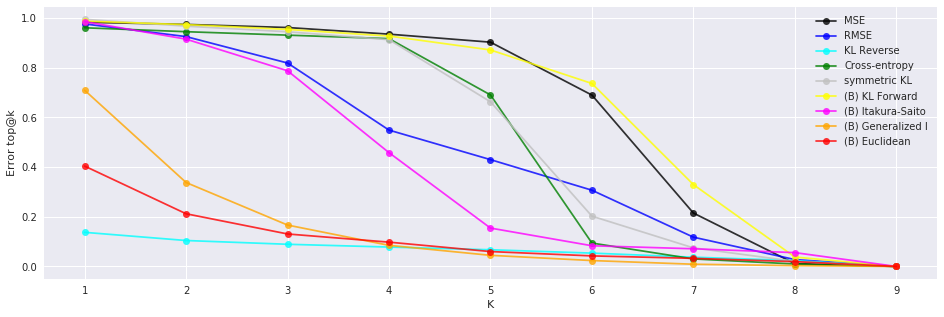

In [23]:
plt.figure(figsize=(16,5))
print("Entrenamiento")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_train,batch_size=128)
    plot_top_k(y_train,y_pred,ind,posibles[ind]) #con test
plt.xticks(np.arange(1,y_test.shape[-1]+1))
plt.ylabel("Error top@k")
plt.xlabel("K")
#plt.ylim(0,0.2)
plt.legend()
plt.show()  

generalized y mse y euclidean las menores... peores igual que antes + symetric KL

In [ ]:
#likelihod prob de cada clase en el dataset

def likelihood_clase(ytrue,ypred): #log
    prediction = np.argmax(ypred,axis=-1)
    epsilon = K.epsilon()
    proba = np.asarray([ytrue[i,prediccion] for i,prediccion in enumerate(prediction)])
    return np.sum(np.log(proba+epsilon))

y_pred = np.asarray([[0.2,0.5,0.2,0.1],[0.2,0.5,0.2,0.1]])
#y_pred2 = np.asarray([[0.15,0.04,0.01,0.8]])
optimo = np.asarray([[0,0,0,1],[0,0,1,0]]) #puede ser la misa prob

y_true = np.asarray([[0.1,0.05,0.05,0.8],[0.001,1,0.001,0.001]]) #como probas..
print("Optimo: ",likelihood_clase(y_true,optimo))
print("Ejemplo: ",likelihood_clase(y_true,y_pred))

In [ ]:
print("On TRAIN set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_train,batch_size=128)
    print("Likelihood de "+posibles[ind]+": ",likelihood_clase(y_train,y_pred))

In [ ]:
print("On TEST set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_test,batch_size=128)
    print("Likelihood de "+posibles[ind]+": ",likelihood_clase(y_test,y_pred))

### Macro F1 Score

In [67]:
y_train_majority = np.zeros_like(y_train)[:,0] #majority vote
for i in range(y_train_majority.shape[0]):
    y_train_majority[i] = y_train[i].argmax()
y_train_majority

array([8., 8., 8., ..., 8., 8., 8.])

In [25]:
from sklearn.metrics import f1_score

iterate = [model_mse,model_rmse,model_klreverse,model_crossentropy,model_symmetricKL
           ,model_klforward,model_itakuras,model_generalizedI,model_euclidean]   
posibles = ["MSE","RMSE","KL Reverse","Cross-entropy","symmetric KL","(B) KL Forward","(B) Itakura-Saito","(B) Generalized I","(B) Euclidean"]

print("On TRAIN set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict_classes(X_train,batch_size=128)
    aux = f1_score(y_train_majority, y_pred, average='macro')
    print("F1 score de "+posibles[ind]+" :",aux)

On TRAIN set


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score de MSE : 0.014153071822593531
F1 score de RMSE : 0.017874271496769702
F1 score de KL Reverse : 0.10286681227003522
F1 score de Cross-entropy : 0.015905441344770163
F1 score de symmetric KL : 0.0056309044142648194
F1 score de (B) KL Forward : 0.00568214471351773
F1 score de (B) Itakura-Saito : 0.01222172303710908
F1 score de (B) Generalized I : 0.0610343907744986
F1 score de (B) Euclidean : 0.09022535877896626


In [26]:
y_test_majority = np.zeros_like(y_test)[:,0] #majority vote
for i in range(y_test_majority.shape[0]):
    y_test_majority[i] = y_test[i].argmax()
y_test_majority

array([1., 8., 8., ..., 8., 8., 8.])

In [27]:
#macro acc..
print("On TEST set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict_classes(X_test,batch_size=128)
    aux = f1_score(y_test_majority, y_pred, average='macro')
    print("F1 score de "+posibles[ind]+" :",aux)

On TEST set


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score de MSE : 0.007877584260649793
F1 score de RMSE : 0.007578763311709611
F1 score de KL Reverse : 0.10862609662180937
F1 score de Cross-entropy : 0.014933922986544553
F1 score de symmetric KL : 0.010670779843002248
F1 score de (B) KL Forward : 0.003972145577311629
F1 score de (B) Itakura-Saito : 0.013162079923687892
F1 score de (B) Generalized I : 0.05598795666694621
F1 score de (B) Euclidean : 0.08652321673759511


* Peor es Itakura Saito seguido de KL Reverse...
* Los que generalizan mejor son Generalized I, MSE, Kl Forward y cross entropy (en ese orden)
* Mejor comportamiento en train se ve reflejado por MSE luego cross entropy+euclidean 

nuevo:
* mismos peores..
* Generaliza mejor: MSE, SymmetricKL, cross entropy y Generalized I
* Mejor en train: cross entropy + MSE---symetric+euclidean 

### MAP

In [28]:
def probabilities_to_indexorder(matrix_dataset): #matrix
    matrix_dataset_position = np.zeros_like(matrix_dataset) #order position labels
    for i in range(matrix_dataset_position.shape[0]):
        aux = sorted(set(matrix_dataset[i]))[::-1]
        j=0
        for valor in aux:
            indexes, = np.where(matrix_dataset[i] == valor)
            for index in indexes:
                matrix_dataset_position[i][j] = index
                j+=1
    return matrix_dataset_position

y_train_position = probabilities_to_indexorder(y_train)
y_test_position = probabilities_to_indexorder(y_test)
y_train_position

array([[8., 1., 2., ..., 4., 6., 7.],
       [8., 0., 1., ..., 4., 5., 7.],
       [8., 0., 2., ..., 5., 6., 7.],
       ...,
       [8., 0., 3., ..., 5., 6., 7.],
       [8., 3., 0., ..., 5., 6., 7.],
       [8., 0., 2., ..., 5., 6., 7.]])

In [29]:
def m_AP_position(true,predicted,k=10):
    #precision por posicion en ranking---disminuyendo su impacto a traves de la posicion
    aux = []
    for i_true,i_predicted in zip(true,predicted):
        score= 0.0
        num_hits = 0.0
        i_predicted = i_predicted[:k]
        for i,p in enumerate(i_predicted):
            if p == i_true[i]: #igualdad
                num_hits += 1.0
                score += num_hits / (i+1.0)
        aux.append( score / min(len(i_true), k) )
    return np.mean(aux)

#y_pred = iterate[0].predict(X_train,batch_size=128)
#y_pred_position = probabilities_to_indexorder(y_pred)

m_AP_position(y_train_position,y_pred_position)

NameError: name 'y_pred_position' is not defined

In [30]:
print("On TRAIN set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_train,batch_size=128)
    y_pred_position = probabilities_to_indexorder(y_pred)
    aux = m_AP_position(y_train_position,y_pred_position)
    print("Supuesto MAP en position de "+posibles[ind]+" :",aux)

On TRAIN set
Supuesto MAP en position de MSE : 0.029513315231914267
Supuesto MAP en position de RMSE : 0.02268235320771553
Supuesto MAP en position de KL Reverse : 0.18854751215862328
Supuesto MAP en position de Cross-entropy : 0.036471861471861475
Supuesto MAP en position de symmetric KL : 0.02153970112907311
Supuesto MAP en position de (B) KL Forward : 0.025082868017650625
Supuesto MAP en position de (B) Itakura-Saito : 0.01844449498435006
Supuesto MAP en position de (B) Generalized I : 0.0780958306320625
Supuesto MAP en position de (B) Euclidean : 0.10568016256422053


In [31]:
print("On TEST set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_test,batch_size=128)
    y_pred_position = probabilities_to_indexorder(y_pred)
    aux = m_AP_position(y_test_position,y_pred_position)
    print("Supuesto MAP en position de "+posibles[ind]+" :",aux)

On TEST set
Supuesto MAP en position de MSE : 0.02981192055946958
Supuesto MAP en position de RMSE : 0.022305542587405337
Supuesto MAP en position de KL Reverse : 0.19184353455186787
Supuesto MAP en position de Cross-entropy : 0.03780139160041121
Supuesto MAP en position de symmetric KL : 0.021168943166492184
Supuesto MAP en position de (B) KL Forward : 0.024413751190711975
Supuesto MAP en position de (B) Itakura-Saito : 0.01751098166539343
Supuesto MAP en position de (B) Generalized I : 0.07720172665025607
Supuesto MAP en position de (B) Euclidean : 0.10701329353290139


* Peor es itakura saito seguido de KL Reverse
* Mejor en train es KL forward seguido de cross entropy+generalizedI/symmetricKL
* Generaliza mejor symmetric KL, segudo de RMSE+crossentropy+generalizedI

NDCG (normalized discount cummulative gain)
relevancia puede ser
* igual... 1
* descuento exponencial 2^len(K)-pos

NDCG se divide por el DCG original/grund truth


In [ ]:
[2**valor-1 for valor in np.arange(9,0,-1)]

In [32]:
relevancia = np.arange(9,0,-1)#np.tile(1,y_test.shape[-1])
#relevancia = np.asarray([2**valor-1 for valor in np.arange(9,0,-1)])

def NDCG(true,predicted):
    aux = []
    discount = [np.log2(i+1) for i in range(1,true.shape[1])]    
    DCG_p_true = relevancia[0]+np.sum(relevancia[1:]/discount) #all have the same true
    for i,data in enumerate(predicted):
        indexes, = np.where(true[i] == data[0])
        DCG_p_predicted = relevancia[indexes[0]]
        for k,element in enumerate(data[1:]):
            indexes, = np.where(true[i] == element)
            DCG_p_predicted+= relevancia[indexes[0]]/discount[k]
        aux.append(DCG_p_predicted/DCG_p_true)
    return np.mean(aux)
    
    #precision por posicion en ranking---disminuyendo su impacto a traves de la posicion
NDCG(y_train_position,y_pred_position)

0.8791980298615256

In [ ]:
from sklearn import metrics
metrics.ndcg_score(y_train_position,y_pred_position)

In [33]:
print("On TRAIN set")
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_train,batch_size=128)
    y_pred_position = probabilities_to_indexorder(y_pred)
    aux = NDCG(y_train_position,y_pred_position)
    print("NDCG en position de "+posibles[ind]+" :",aux)

On TRAIN set
NDCG en position de MSE : 0.8286883355871167
NDCG en position de RMSE : 0.8216531970391071
NDCG en position de KL Reverse : 0.9149482204978715
NDCG en position de Cross-entropy : 0.8428704398320773
NDCG en position de symmetric KL : 0.7690278680140642
NDCG en position de (B) KL Forward : 0.8132543009060414
NDCG en position de (B) Itakura-Saito : 0.7583890499059683
NDCG en position de (B) Generalized I : 0.8798241519012319
NDCG en position de (B) Euclidean : 0.8791409304272619


In [34]:
print("On TEST set")
valores_NDCG = []
for ind in range(len(posibles)):
    y_pred = iterate[ind].predict(X_test,batch_size=128)
    y_pred_position = probabilities_to_indexorder(y_pred)
    aux = NDCG(y_test_position,y_pred_position)
    valores_NDCG.append(aux)
    print("NDCG en position de "+posibles[ind]+" :",aux)

On TEST set
NDCG en position de MSE : 0.832250669394545
NDCG en position de RMSE : 0.8245899174599999
NDCG en position de KL Reverse : 0.917904810899881
NDCG en position de Cross-entropy : 0.8414796822267497
NDCG en position de symmetric KL : 0.7725523253548534
NDCG en position de (B) KL Forward : 0.8147657320128343
NDCG en position de (B) Itakura-Saito : 0.75736142959814
NDCG en position de (B) Generalized I : 0.8814061768681332
NDCG en position de (B) Euclidean : 0.8779515749294419


* el que generaliza mejor Generalized I y cross entropy y mse
* peor igual que siempre...
* Mejor en train... symmetricKL+KLforward+GeneralizedI+crossentropy